# Analysis of BTSP-enabled local sensitive hashing performance 3

In [1]:
# import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
import xgboost as xgb

## Load dataset and check data

In [3]:
# load results.csv
results1 = pd.read_csv('merged_results.csv')
results2 = pd.read_csv('optimal_btsp_mAP.csv')
# NOTE(Ruhao Tian): here the optimal_btsp_mAP.csv is the result of analysis part 2.

# print dataset length
print(len(results1))

# print schema
print(results1.dtypes)

print(len(results2))
print(results2.dtypes)

140
Unnamed: 0                       int64
dataset_name                    object
training_data_num                int64
hash_length                      int64
space_ratio                      int64
btsp_fq_constant                object
binary_mode                       bool
btsp_sampling_ratio             object
random_seed                      int64
experiment_index                 int64
input_dim                        int64
embedding_size                   int64
optimal_btsp_fq_constant         int64
optimal_btsp_sampling_ratio    float64
optimal_btsp_fq                float64
btsp_mAP                       float64
fly_mAP                        float64
wta_mAP                        float64
lsh_mAP                        float64
dtype: object
28
dataset_name              object
hash_length                int64
space_ratio                int64
btsp_fq_constant_x         int64
btsp_sampling_ratio_x    float64
btsp_mAP                 float64
dtype: object


## Performance analysis between the BTSP and FLY algorithms

In this section, we compare mAP performance between the fine-tuned BTSP and the Fly algorithm against each `hash_length` and each `dataset`.

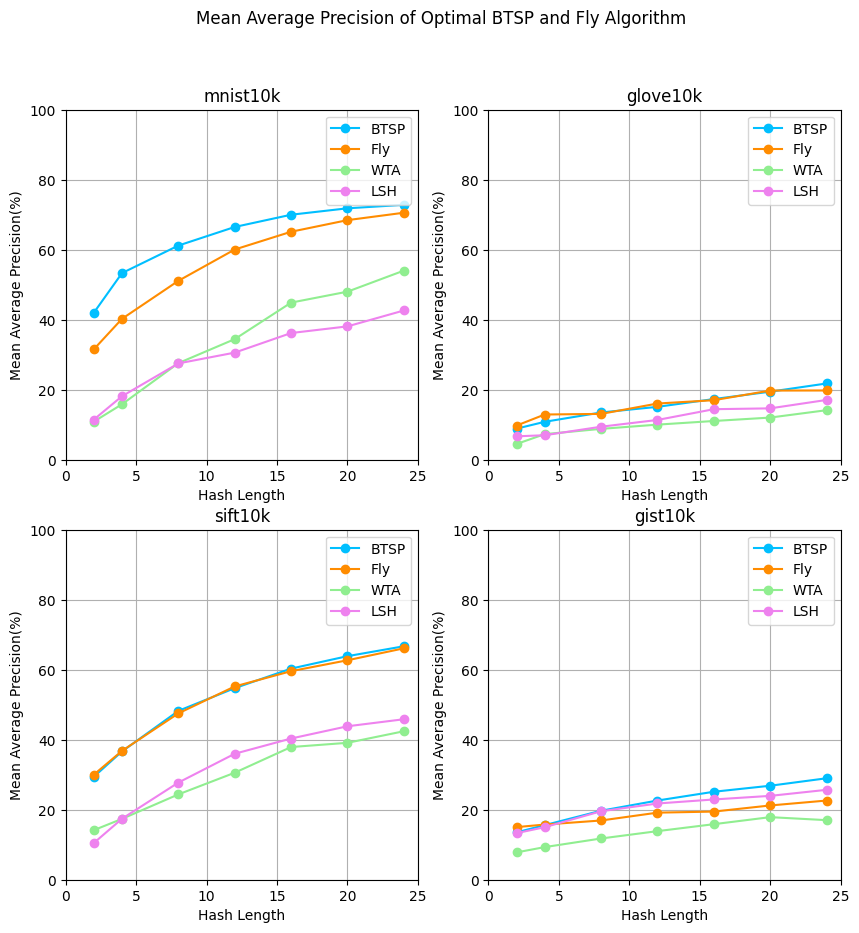

In [4]:
# load data
optimal_btsp = pd.read_csv('optimal_btsp_mAP.csv')
fly_data = pd.read_csv('merged_results.csv')

# plot the mAP of optimal_btsp
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
datasets = ["mnist10k","glove10k","sift10k","gist10k"]
for index, dataset in enumerate(datasets):
    # separate data
    data_btsp = optimal_btsp[optimal_btsp['dataset_name'] == dataset]
    data_fly = fly_data[fly_data['dataset_name'] == dataset]
    
    # plot btsp mAP against hash length, scale mAP to percentage
    axs[index//2, index%2].plot(data_btsp['hash_length'], data_btsp['btsp_mAP'].multiply(100), label='BTSP', marker="o", linestyle="-", color='deepskyblue')
    # extract fly data
    sampling_ratio = data_btsp[['hash_length', 'space_ratio']]
    # find the records with the same (hash_length, space_ratio) pairs in fly_data
    fly_data_selected = data_fly.merge(sampling_ratio, on=['hash_length', 'space_ratio'], how='inner')
    # reorder the fly_data_selected by hash_length
    fly_data_selected = fly_data_selected.sort_values(by=['hash_length'])
    # plot fly mAP against hash length and other reference models, scale mAP to percentage
    axs[index//2, index%2].plot(fly_data_selected['hash_length'], fly_data_selected['fly_mAP'].multiply(100), label='Fly', marker="o", linestyle="-", color='darkorange')
    axs[index//2, index%2].plot(fly_data_selected['hash_length'], fly_data_selected['wta_mAP'].multiply(100), label='WTA', marker="o", linestyle="-", color='lightgreen')
    axs[index//2, index%2].plot(fly_data_selected['hash_length'], fly_data_selected['lsh_mAP'].multiply(100), label='LSH', marker="o", linestyle="-", color='violet')
    axs[index//2, index%2].set_xlim(0,25)
    axs[index//2, index%2].set_ylim(0,100)
    axs[index//2, index%2].set_xlabel('Hash Length')
    axs[index//2, index%2].set_ylabel('Mean Average Precision(%)')
    axs[index//2, index%2].legend()
    axs[index//2, index%2].grid()
    axs[index//2, index%2].set_title(dataset)
fig.suptitle('Mean Average Precision of Optimal BTSP and Fly Algorithm')
# save as svg
plt.savefig('mAP_optimal_btsp_fly.svg')
plt.show()

We've shown that the fine-tuned BTSP algorithm outperforms the Fly algorithm in the previous section. Note that here the Fly algorithm is under default settings, with the same `space_ratio` as BTSP and without any fine-tuning.

### Report diagram of comparison between BTSP and Fly algorithms

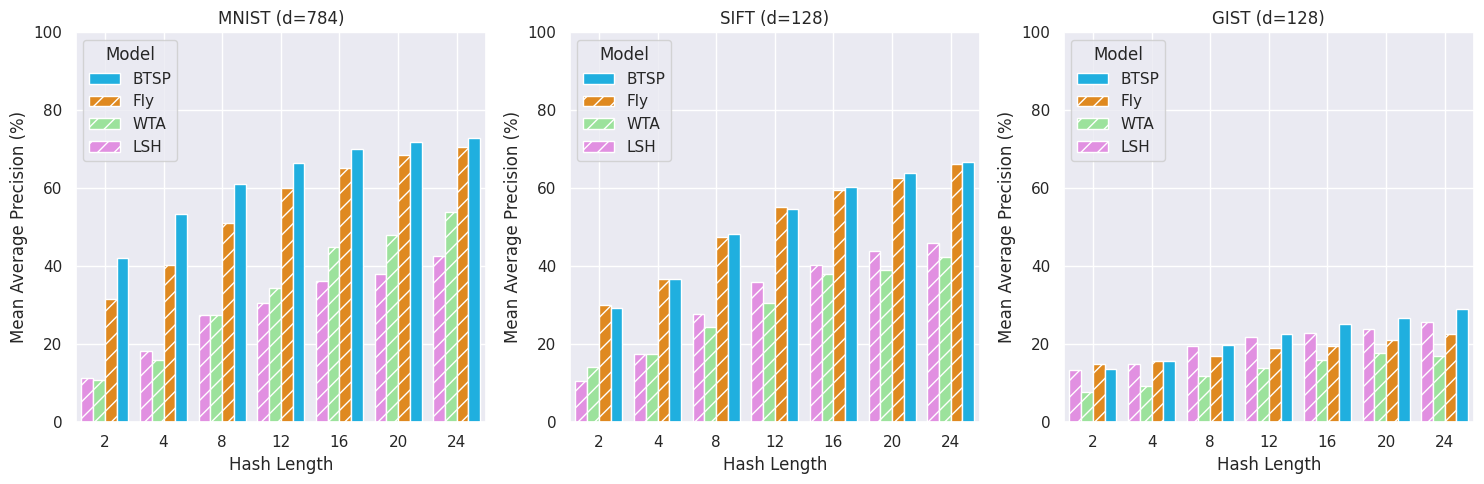

In [103]:
# load data
optimal_btsp = pd.read_csv("optimal_btsp_mAP.csv")
ref_data = pd.read_csv("merged_results.csv")

# data cleaning
# keep only the columns of interest
optimal_btsp = optimal_btsp[["dataset_name", "hash_length", "space_ratio", "btsp_mAP"]]
ref_data = ref_data[
    ["dataset_name", "hash_length", "space_ratio", "fly_mAP", "wta_mAP", "lsh_mAP"]
]
# remove all data from glove10k dataset
optimal_btsp = optimal_btsp[optimal_btsp["dataset_name"] != "glove10k"]
ref_data = ref_data[ref_data["dataset_name"] != "glove10k"]
# for ref_data, keep the records with the same (dataset_name, hash_length, space_ratio) pairs in optimal_btsp
ref_data = ref_data.merge(
    optimal_btsp, on=["dataset_name", "hash_length", "space_ratio"], how="inner"
)
ref_data = ref_data.drop(columns=["btsp_mAP"])
# merge optimal_btsp and ref_data to data
data = optimal_btsp.merge(
    ref_data, on=["dataset_name", "hash_length", "space_ratio"], how="inner"
)
# reorder all data by 1. dataset_name, 2. hash_length, 3. space_ratio
data = data.sort_values(by=["dataset_name", "hash_length", "space_ratio"])
# print(data.columns)
# rename for better visualization
# rename mAP columns
data = data.rename(
    columns={
        "btsp_mAP": "BTSP",
        "fly_mAP": "Fly",
        "wta_mAP": "WTA",
        "lsh_mAP": "LSH",
    }
)
# rename dataset names
data["dataset_name"] = data["dataset_name"].replace(
    {
        "mnist10k": "MNIST (d=784)",
        "sift10k": "SIFT (d=128)",
        "gist10k": "GIST (d=128)",
    }
)
# reshape data to use seaborn hue
data = data.melt(
    id_vars=["dataset_name", "hash_length", "space_ratio"],
    var_name="model",
    value_name="mAP",
    value_vars=["BTSP", "Fly", "WTA", "LSH"],
)
# scale mAP to percentage
data["mAP"] = data["mAP"] * 100

import seaborn as sns
import math

# Set the context and style
sns.set_style("darkgrid")
sns.set_context("notebook")

# Create a figure and axis
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
dataset_order = ["MNIST (d=784)", "SIFT (d=128)", "GIST (d=128)"]
bar_order = ["BTSP", "Fly", "WTA", "LSH"]
palette = ["deepskyblue", "darkorange", "lightgreen", "violet"]
hatches = ["", "//", "//", "//"]
for dataset in dataset_order:
    ax = axs[dataset_order.index(dataset)]
    # Create a subplot for each dataset
    sns.barplot(
        x="hash_length",
        y="mAP",
        hue="model",
        data=data[data["dataset_name"] == dataset],
        ax=ax,
        hue_order=bar_order[::-1],
        palette=palette[::-1],
    )
    # Set the title and labels
    ax.set_title(dataset)
    ax.set_xlabel("Hash Length")
    ax.set_ylabel("Mean Average Precision (%)")
    ax.set_ylim(0, 100)
    # add x-axis grid
    ax.xaxis.grid(True)
    
    # apply hatches
    bar_num = len(ax.patches)
    group_num = len(bar_order)
    bar_group_num = int(bar_num / group_num) - 1
    # print(bar_num)
    for index, bar in enumerate(ax.patches):
        if index < bar_num - group_num:
            bar.set_hatch(hatches[::-1][math.floor(index / bar_group_num)])
        else:
            # set hatch for legend
            bar.set_hatch(hatches[::-1][index - (bar_num - group_num)])
    # flip legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title="Model", loc="upper left")
    

# Adjust layout for better fit
plt.tight_layout()
# save as svg
plt.savefig('mAP_optimal_btsp_fly_seaborn.svg')
# save as png
plt.savefig('mAP_optimal_btsp_fly_seaborn.png')
plt.show()